# Pricing d'options par le modèle binomial à N périodes
### 1e étape : Simuler le prix du sous-jacent de prix initial $S_0$ à t=0

A chaque noeud, le prix change par les quantités suivantes :  

- En haut par la quantité $ u = exp(\sigma \sqrt\Delta t)$ avec une probabilité $p = \frac{exp(r \Delta t) - d}{u-d}$ 
- En bas par la quantité $ d = 1/u = exp(-\sigma \sqrt\Delta t)$ avec une probabilité $q = 1-p $ 

Pour un noeud $ P_{i,k}$, le prix au 2 noeuds de la période suivante $ k+1$ sont : 
- Noeud en haut :  $ P_{i,k+1} = uPrix_{i,k}$
- Noeud en haut :  $ P_{i+1,k+1} = dPrix_{i,k}$

### 2e étape : Evaluation par induction arrière

1- L'évalation commence par déterminer le pay-off des noeuds finaux :

Pour tout $i \in [0,N]$ : 
- Si Put : $C_{i,N} = max(K-S_T,0) $
- Si Call : $C_{i,N} = max(S_T-K,0) $

2- On évalue en partant des noeuds de la dernière période :

$$ C_{i,t} = exp(-r\Delta t) [ pC_{i,t+\Delta t} + (1-p)C_{i+1,t+\Delta t}]$$ 
- Pour une option Européenne : il n’y pas la possibilité d’exercer de manière anticipée et la valeur binomiale est utilisée à chaque nœud : $C_{i,t}$
- Pour une option Américaine : puisque l’option peut être conservée ou exercée avant l’échéance, la valeur de chaque nœud est $ max(C_{i,t}, P_{i,t} - K$ si call et $K-P_{i,t}$ si Put $) $
- Pour une option Bermudienne : 
    - Si exercice anticipé autorisé au noeud : l'option est évaluée comme une option Américaine : $max(C_{i,t}, P_{i,t} - K$ si call et $K-P_{i,t}$ si Put $)$
    - Si exercice anticipé n’est pas autorisé au noeud : l'option est évaluée comme une option Européene : $C_{i,t}$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def dates_exercice(N, maturite, freq):
    dt = maturite/N
    noeuds = np.arange(0, maturite+dt,dt)
    dates = np.arange(freq, maturite, freq)
    dates = np.append(dates, maturite)
    L=[]
    for i in range(len(noeuds)):
        for j in range(len(dates)):
            if round(noeuds[i],5) == round(dates[j],5) :
                L.append(i)
                break
    return L

In [3]:
def modele_binomial(N, maturite, s0, sigma, K, r, frequence=0, call=True, type_option="European", show_mat=False):
    """
    N : nombre de périodes du modèle
    maturite : Maturité de l'option
    s0 : Prix initial du sous-jacent
    sigma : volatilité du sous-jacent
    K : prix d'exercice de l'option
    r : taux sans risque
    frequence : dans le cas d'une option bermudienne, c'est la durée entre deux dates où l'exercice de l'option est possible
    call : booléen, signifie call si True et put sinon
    type_option : type de l'option : "American", "European" ou "Bermudan"
    show_mat : affiche l'arbre de prix de l'option si True, et le prix actuel si False
    """
    dt = maturite/N
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt)-d)/(u-d)
       
    arbre_prix = np.zeros([N+1,N+1])
    for j in range(N+1):
        for i in range(j+1):
            arbre_prix[i, j] = round(s0*(d**(i))*(u**(j-i)),2)
            
    prix_option = np.zeros([N+1,N+1])  
    if call:
        prix_option[:,N] = np.maximum(np.zeros(N+1), arbre_prix[:,N]-K)
    else:
        prix_option[:,N] = np.maximum(np.zeros(N+1), K-arbre_prix[:,N])
    
    if type_option=="European":
        for j in range(N-1,-1,-1):
            for i in range(0,j+1):
                prix_option[i,j] = round(np.exp(-r*dt)*(p*prix_option[i,j+1]+(1-p)*prix_option[i+1,j+1]),2)
                
    elif type_option=="American":
        if call:
            for j in range(N-1,-1,-1):
                for i in range(0,j+1):
                    prix_option[i,j] = round(np.maximum(np.exp(-r*dt)*(p*prix_option[i,j+1]+(1-p)*prix_option[i+1,j+1]), arbre_prix[i,j]-K),2)
        else:
            for j in range(N-1,-1,-1):
                for i in range(0,j+1):
                    prix_option[i,j] = round(np.maximum(np.exp(-r*dt)*(p*prix_option[i,j+1]+(1-p)*prix_option[i+1,j+1]), K-arbre_prix[i,j]),2)
    elif type_option=="Bermudan":
        L=dates_exercice(N, maturite, frequence)        
        if call:
            for j in range(N-1,-1,-1):
                for i in range(0,j+1):
                    if j in L:
                        prix_option[i,j] = round(np.exp(-r*dt)*(p*prix_option[i,j+1]+(1-p)*prix_option[i+1,j+1]),2)
                    else:
                        prix_option[i,j] = round(np.maximum(np.exp(-r*dt)*(p*prix_option[i,j+1]+(1-p)*prix_option[i+1,j+1]), arbre_prix[i,j]-K),2)
        else:
            for j in range(N-1,-1,-1):
                for i in range(0,j+1):
                    if j in L:
                        prix_option[i,j] = round(np.exp(-r*dt)*(p*prix_option[i,j+1]+(1-p)*prix_option[i+1,j+1]),2)
                    else:
                        prix_option[i,j] = round(np.maximum(np.exp(-r*dt)*(p*prix_option[i,j+1]+(1-p)*prix_option[i+1,j+1]), K-arbre_prix[i,j]),2)
                    
    if show_mat: 
        return prix_option
    return prix_option[0,0]

In [7]:
modele_binomial(N=36, maturite=18/12, s0=50, sigma=0.4, K=50, r=0.1, call=False, type_option="European")

5.86

In [5]:
modele_binomial(N=36, maturite=18/12, s0=50, sigma=0.4, K=50, r=0.1, call=False, type_option="American")

6.82

In [171]:
modele_binomial(N=36, maturite=18/12, s0=50, sigma=0.4, K=50, r=0.1, call=False, frequence=1/12, type_option="Bermudan")

6.79

In [58]:
binomial_puts = pd.DataFrame(columns=["European","American","Bermudan"], index=np.arange(100))
binomial_calls = pd.DataFrame(columns=["European","American","Bermudan"], index=np.arange(100))

for type in binomial_puts.columns:
    for s in range(100):
        binomial_calls.iloc[s][type] = modele_binomial(N=72, maturite=18/12, s0=s, sigma=0.15, K=50, r=0.05, frequence=1/48, call=True, type_option=type)
        binomial_puts.iloc[s][type] = modele_binomial(N=72, maturite=18/12, s0=s, sigma=0.15, K=50, r=0.05, frequence=1/48, call=False, type_option=type)

Text(0, 0.5, 'Prix Option')

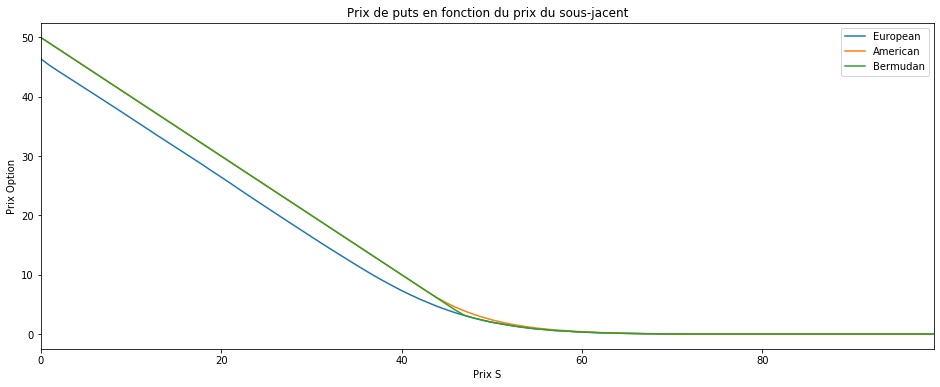

In [59]:
binomial_puts.plot(figsize=(16,6), title="Prix de puts en fonction du prix du sous-jacent")
plt.xlabel("Prix S")
plt.ylabel("Prix Option")

Text(0, 0.5, 'Prix Option')

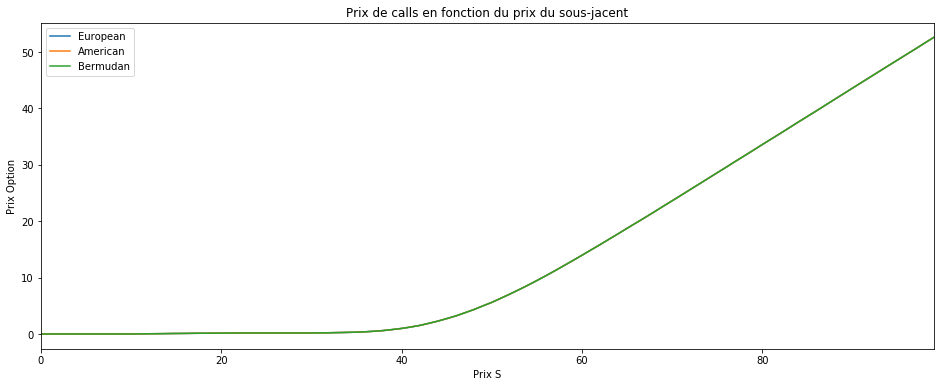

In [61]:
binomial_calls.plot(figsize=(16,6), title="Prix de calls en fonction du prix du sous-jacent")
plt.xlabel("Prix S")
plt.ylabel("Prix Option")

In [7]:
periodes = np.arange(1,51)
cols = ["Bermudan Put","Bermudan Call","American Put","American Call","European Put","European Call"]
u = pd.DataFrame(columns=cols, index=periodes)

for i in periodes:
    u.loc[i]["Bermudan Put"] = modele_binomial(N=i, maturite=5/12, s0=50, sigma=0.4, K=50, r=0.1, call=False, frequence=1/12, type_option="Bermudan")
    u.loc[i]["Bermudan Call"] = modele_binomial(N=i, maturite=5/12, s0=50, sigma=0.4, K=50, r=0.1, call=True, frequence=1/12, type_option="Bermudan")
    u.loc[i]["American Put"] = modele_binomial(N=i, maturite=5/12, s0=50, sigma=0.4, K=50, r=0.1, call=False, type_option="American")
    u.loc[i]["American Call"] = modele_binomial(N=i, maturite=5/12, s0=50, sigma=0.4, K=50, r=0.1, call=True, type_option="American")
    u.loc[i]["European Put"] = modele_binomial(N=i, maturite=5/12, s0=50, sigma=0.4, K=50, r=0.1, call=False, type_option="European")
    u.loc[i]["European Call"] = modele_binomial(N=i, maturite=5/12, s0=50, sigma=0.4, K=50, r=0.1, call=True, type_option="European")                               

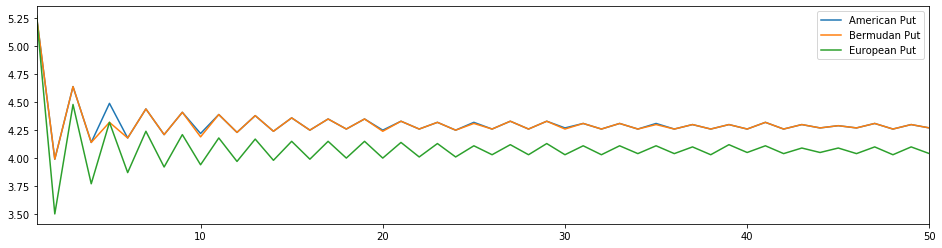

In [13]:
u[["American Put","Bermudan Put","European Put"]].plot(figsize=(16,8))

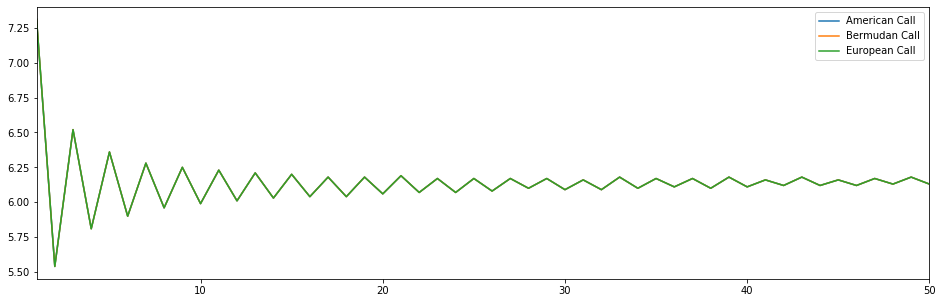

In [12]:
u[["American Call","Bermudan Call","European Call"]].plot(figsize=(16,5))

# Pricing d'options par Simulations de Monte Carlo

L'évaluation des options par simulations de Monte Carlo repose en grande partie sur l'évaluation risque-neutre. Les paiements futurs espérés sont en effet calculés dans l'univers risque-neutre en suivant une procédure d'échantillonnage, avant d'être actualisés au taux d'intérêt sans risque. Considérons un actif dérivé ayant pour support une variable de marché ,5 et délivrant un payoff à la date 7. Avec des taux d'intérêt supposés constants, il est possible d'évaluer cet actif dérivé de Ia manière suivante :

1. Tirer au hasard une trajectoire de S dans I'univers risque-neutre.
2. Calculer 1e flux payé à l'échéance par l'actif dérivé pour cette trajectoire.
3. Répéter 1es étapes 1 et 2 de façon à disposer d'un grand nombre de flux terminaux de l'actif dérivé dans I'univers risque-neutre.
4. Calculer la moyenne des flux terminaux pour obtenir une estimation de I'espérance du flux terminal dans l'univers risque-neutre.
5. Actualiser le flux terminal espéré au taux d'intérêt sans risque pour obtenir une estimation de la valeur de I'actif dérivé.

##### Supposons que, dans l'univers risque-neutre, la variable de marché sous-jacente S suive le processus suivant :
$$ dS = \mu S dt + \sigma S dz$$ 
avec : $\mu$ son rendement espéré, $ \sigma$ sa volatilité, $z$ un processus de Wiener modélisant un mouvement brownien

- Etape 1 : subdivision de la maturité T en N intervalles de durée $\Delta t = T/N $
- Etape 2 : simuler la trajectoire suivie par $S$ en approximant l'équation : 
$$ S(t+\Delta t) = S(t)exp^{(\mu - \frac{\sigma^2}{2})\Delta t +\sigma  \epsilon \sqrt \Delta t}$$ 

In [62]:
def simul_price(s0=50, n_scenarios=100, T=1, mu=0.08, sigma=0.15, N=100):
    dt = T/N
    eps = np.random.normal(size=(N, n_scenarios))
    u = pd.DataFrame(np.exp((mu - (sigma**2)/2)*dt + sigma*np.sqrt(dt)*eps), columns=np.arange(1,n_scenarios+1) , index=np.arange(dt, T+dt, dt))
    prices = s0*u.cumprod()
    return prices

In [63]:
mc = simul_price(s0=50, n_scenarios=500, T=1, mu=0.06, sigma=0.15, N=360)

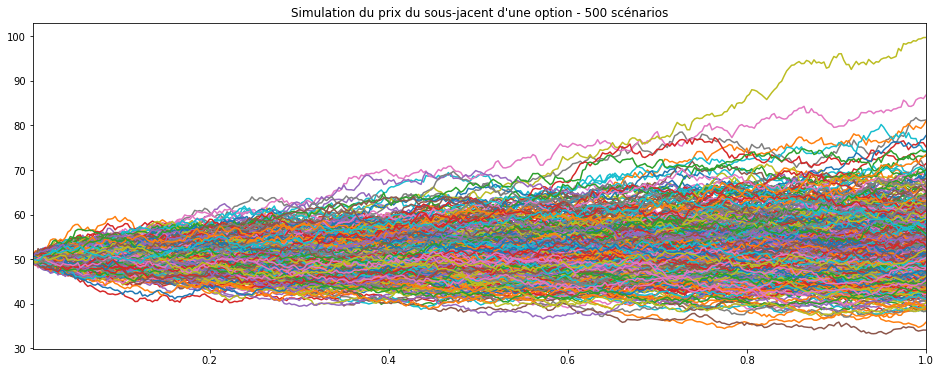

In [64]:
mc.plot(figsize=(16,6), title="Simulation du prix du sous-jacent d'une option - 500 scénarios", legend=False)

### Pricing d'options
Les outputs de la fonction seront comme suit :
- Option européenne : moyenne des payoffs à maturité
- Option américaine : vecteur moyenne des payoffs à chaque date (de 0 à N)
- Option bermudienne : vecteur moyenne des payoffs à chaque date ou l'exercice anticipé est possible

In [146]:
def pricing_option(T=1, K=50, call=True,optionType = "European", s0=50, n_scenarios=1000, mu=0.08, sigma=0.15, r=0.05, N=100, freq=0):
    
    if optionType == "European":
        mc = simul_price(s0, n_scenarios, T, mu, sigma, N)
        if call:
            payoff = (mc.iloc[-1]-K)*np.exp(-r*T)
        else:
            payoff = (K-mc.iloc[-1])*np.exp(-r*T)
        for i in payoff.index:
            if payoff.loc[i]<0:
                payoff.loc[i] = 0
        return payoff.mean()
    
    elif optionType == "American":
        mc = simul_price(s0, n_scenarios, T, mu, sigma, N)
        if call:
            payoff = mc-K
            for i in range(1,n_scenarios+1):
                payoff[i] = payoff[i]*np.exp(-r*mc.index)
        else :
            payoff = K-mc
            for i in range(1,n_scenarios+1):
                payoff[i] = payoff[i]*np.exp(-r*mc.index)
            
        payoff[payoff<0]=0
        
        am = payoff.mean(axis=1)
        return am
    elif optionType=="Bermudan":
        N = int(T/freq)
        mc = simul_price(s0, n_scenarios, T, mu, sigma, N)
        if call:
            payoff = mc-K
            for i in range(1,n_scenarios+1):
                payoff[i] = payoff[i]*np.exp(-r*mc.index)
        else :
            payoff = K-mc
            for i in range(1,n_scenarios+1):
                payoff[i] = payoff[i]*np.exp(-r*mc.index)
            
        payoff[payoff<0]=0
        
        bm = payoff.mean(axis=1)
        return bm

#### Evolution prix d'options américaines jusqu'à maturité

In [160]:
options_amer = pd.DataFrame(columns=["Put","Call"])
options_amer.Put = pricing_option(T=1, K=50, call=False, optionType = "American", s0=50, n_scenarios=1000, mu=0.15, sigma=0.35, r=0.05, N=360)
options_amer.Call = pricing_option(T=1, K=50, call=True, optionType = "American", s0=50, n_scenarios=1000, mu=0.15, sigma=0.35, r=0.05, N=360)

Text(0, 0.5, 'Prix option')

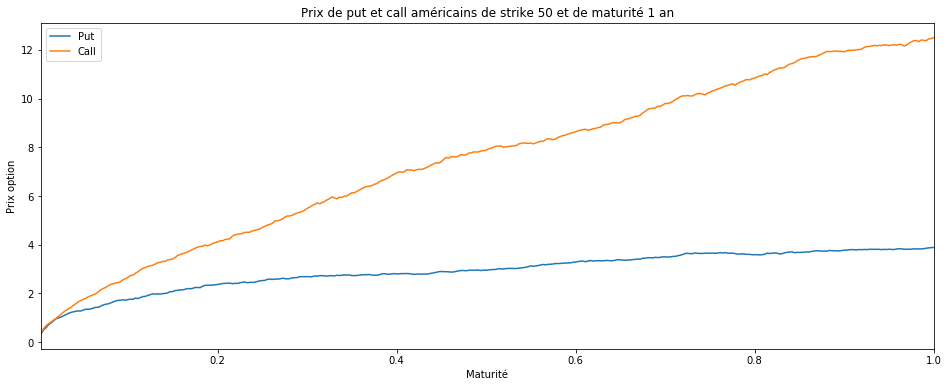

In [161]:
options_amer[["Put","Call"]].plot(figsize=(16,6), title="Prix de put et call américains de strike 50 et de maturité 1 an")
plt.xlabel("Maturité")
plt.ylabel("Prix option")

#### Evolution prix d'options bermudiennes jusqu'à maturité

In [162]:
options_bermud = pd.DataFrame(columns=["Put","Call"])
options_bermud.Put = pricing_option(T=2, K=50, call=False, optionType = "Bermudan", s0=50, n_scenarios=1000, mu=0.15, sigma=0.35, r=0.05, freq=1/(12*4))
options_bermud.Call = pricing_option(T=2, K=50, call=True, optionType = "Bermudan", s0=50, n_scenarios=1000, mu=0.15, sigma=0.35, r=0.05, freq=1/(12*4))

Text(0, 0.5, 'Prix option')

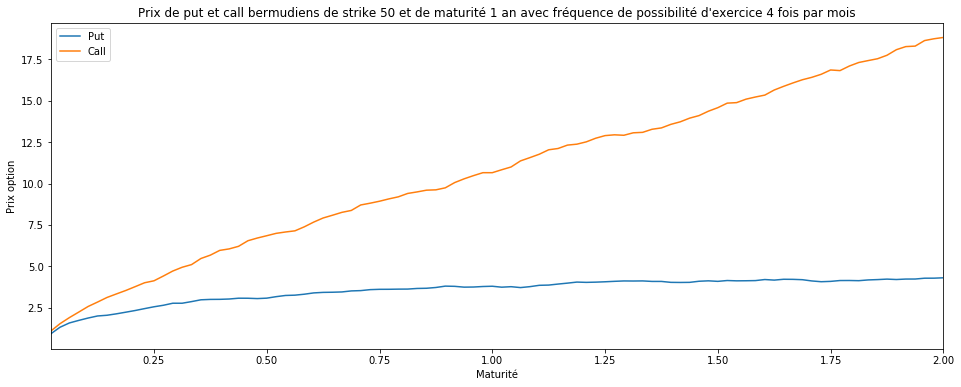

In [164]:
options_bermud[["Put","Call"]].plot(figsize=(16,6), 
                                    title="Prix de put et call bermudiens de strike 50 et de maturité 1 an" 
                                    +" avec fréquence de possibilité d'exercice 4 fois par mois")
plt.xlabel("Maturité")
plt.ylabel("Prix option")

#### Evolution du prix d'option en fonction du prix du sous-jacent

In [166]:
prixOption_prixSsJacent = pd.DataFrame(columns=["Put","Call"], index = np.arange(0,100))
for s in range(100):
    prixOption_prixSsJacent.iloc[s]["Call"] = pricing_option(T=1, K=50, call=True, optionType = "European", s0=s, n_scenarios=1000, mu=0.15, sigma=0.3, N=100)
    prixOption_prixSsJacent.iloc[s]["Put"] = pricing_option(T=1, K=50, call=False, optionType = "European", s0=s, n_scenarios=1000, mu=0.15, sigma=0.3, N=100)

Text(0.5, 0, 'Prix Sous-jacent S')

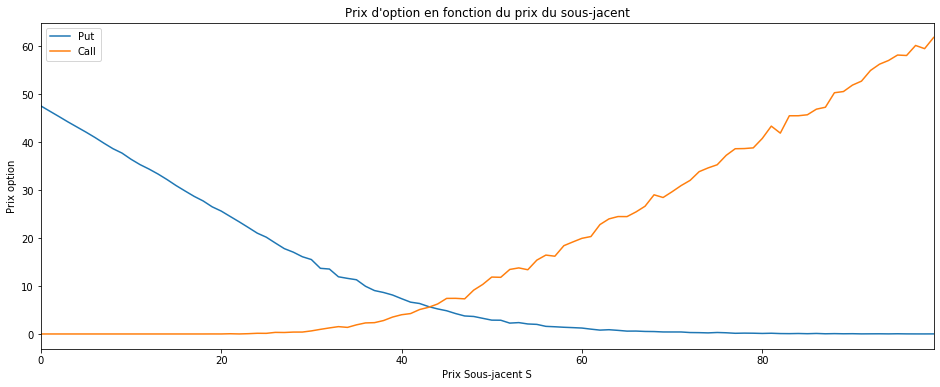

In [167]:
prixOption_prixSsJacent.plot(figsize=(16,6), title="Prix d'option en fonction du prix du sous-jacent")
plt.ylabel("Prix option")
plt.xlabel("Prix Sous-jacent S")